In [121]:
import iris
import iris.coord_categorisation
import calendar
import os
import numpy as np
import xarray as xr
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

In [146]:
def gpcc_indices():
    gpcc_directory = "/gws/pw/j05/cop26_hackathons/bristol/project02/data/obs/TRBindices/GPCC"
    gpcc_filename = "pr_1m_zonAvgNikulin_GPCC_1891-2019_05.nc"
    ds_gpcc = xr.open_dataset(f"{gpcc_directory}/{gpcc_filename}")
    return ds_gpcc.sel(time=slice('1970-01-01', '2000-01-01'))

In [139]:
def historical_indices(model_name):
    historical_directory = f"/gws/pw/j05/cop26_hackathons/bristol/project02/data/CMIP6histo/TRBindices/{model_name}"
    historical_filename = f"pr_1m_zonAvgNikulin_{model_name}_historical_s1850.nc"
    ds_historical = xr.open_dataset(f"{historical_directory}/{historical_filename}")
    return ds_historical.sel(time=slice('1970-01-01', '2000-01-01'))

In [141]:
def future_indices(model_name, scenario):
    future_directory = f"/gws/pw/j05/cop26_hackathons/bristol/project02/data/CMIP6proj/TRBindices/{model_name}"
    future_filename = f"pr_1m_zon_Avg_Nikulin_{model_name}_{scenario}_s2015.nc"
    ds_future = xr.open_dataset(f"{future_directory}/{future_filename}")
    return ds_future.sel(time=slice('2070-01-01', '2100-01-01'))

In [142]:
def trb_index_label(trb_index):
    index_labels = {'amplitude': 'Intensity (mm/day)',
                    'mean': 'Location (deg N)',
                    'width': 'Width (deg)'}
    return index_labels[trb_index]

# Compare all TRB indices between historical simulations 1970-2000 and future projections 2070-2100

In [10]:
def compare_time_slices_model(model_name, scenario, trb_index, ax=None):
    #example model name HadGEM3-GC31-MM
    #example scenario ssp585
    #trb_index either 'amplitude', 'mean' or 'width'
    
    ds_historical = historical_indices(model_name)
    ds_future = future_indices(model_name, scenario)
    
    trb_index_historical = ds_historical.gaussian_params.sel(popt=trb_index)
    trb_index_future = ds_future.gaussian_params.sel(popt=trb_index)
    if trb_index == 'width':
        trb_index_historical = np.fabs(trb_index_historical)
        trb_index_future = np.fabs(trb_index_future)
        trb_index_historical = xr.where(trb_index_historical < 20., trb_index_historical, np.nan)
        trb_index_future = xr.where(trb_index_future < 20., trb_index_future, np.nan)
    elif trb_index == 'mean':
        trb_index_historical = xr.where(np.fabs(trb_index_historical) < 25., trb_index_historical, np.nan)
        trb_index_future = xr.where(np.fabs(trb_index_future) < 25., trb_index_future, np.nan)
    elif trb_index == 'amplitude':
        trb_index_historical = xr.where(trb_index_historical < 50., trb_index_historical, np.nan)
        trb_index_future = xr.where(trb_index_future < 50., trb_index_future, np.nan)
    
    trb_monthly_historical = trb_index_historical.groupby("time.month")
    trb_monthly_future = trb_index_future.groupby("time.month")
    
    months = np.arange(1, 13)
    month_labels = [m for m in calendar.month_abbr[1:]]
    
    if not ax:
        ax = plt.gca()
    ax.plot(months, trb_monthly_historical.mean("time"), color='k', label='historical')
    ax.fill_between(months, trb_monthly_historical.reduce(np.percentile, q=10), trb_monthly_historical.reduce(np.percentile, q=90), facecolor='k', alpha=0.5)
    ax.plot(months, trb_monthly_future.mean("time"), color='r', label=scenario)
    ax.legend(loc='best')
    ax.plot(months, trb_monthly_future.reduce(np.percentile, q=10), '--', color='r', alpha=0.5)
    ax.plot(months, trb_monthly_future.reduce(np.percentile, q=90), '--', color='r', alpha=0.5)
    ax.set_xticks(months[::2])
    ax.set_xticklabels(month_labels[::2])
    ax.set_ylabel(trb_index_label(trb_index))
    ax.set_title(model_name)
    return ax

Compare historical with SSP119 (for models that have SSP119 data)

/opt/jaspy/lib/python3.7/site-packages/numpy/lib/function_base.py:3652: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/opt/jaspy/lib/python3.7/site-packages/numpy/lib/function_base.py:3652: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/opt/jaspy/lib/python3.7/site-packages/numpy/lib/function_base.py:3652: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/opt/jaspy/lib/python3.7/site-packages/numpy/lib/function_base.py:3652: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/opt/jaspy/lib/python3.7/site-packages/numpy/lib/function_base.py:3652: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/opt/jaspy/lib/python3.7/site-packages/numpy/lib/function_base.py:3652: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


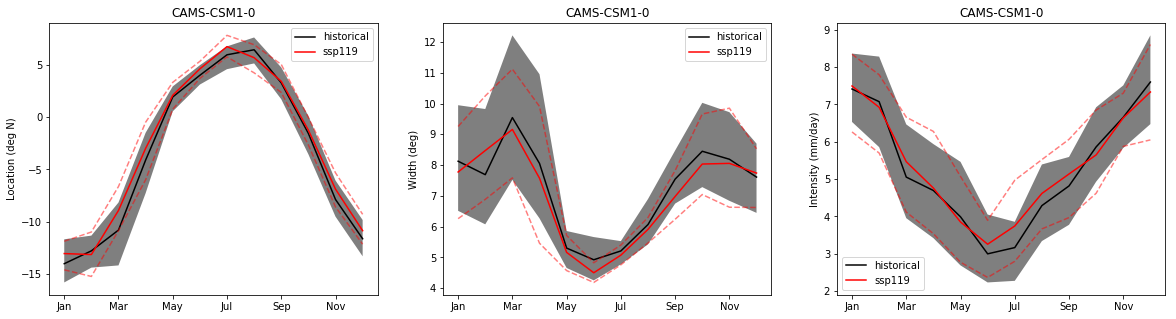

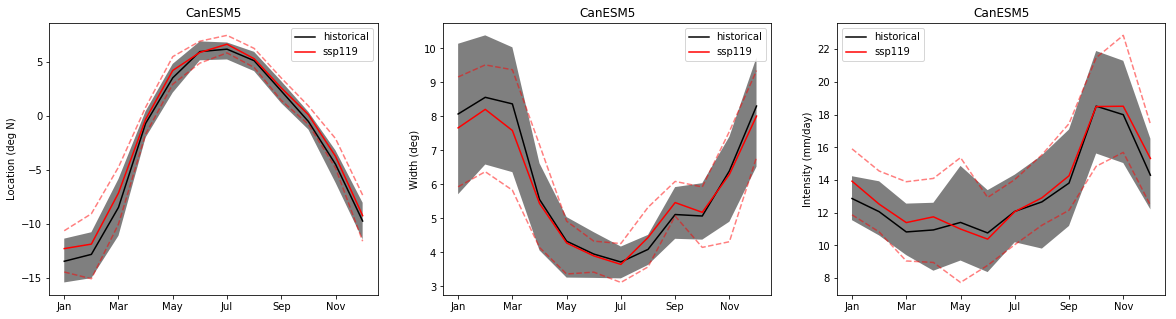

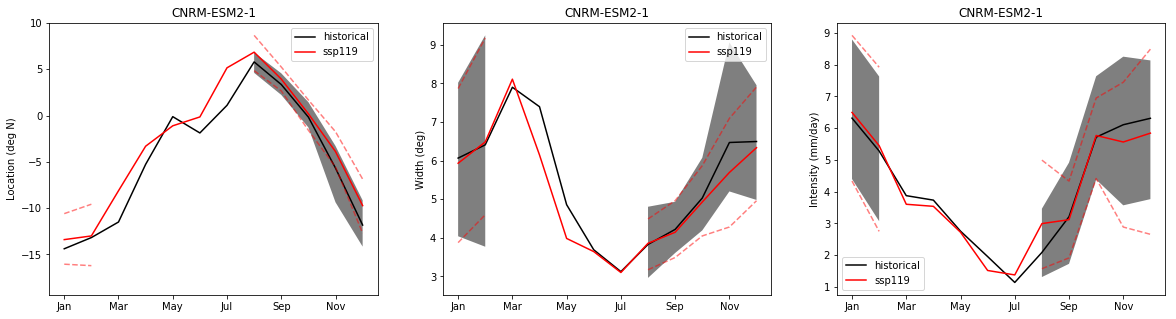

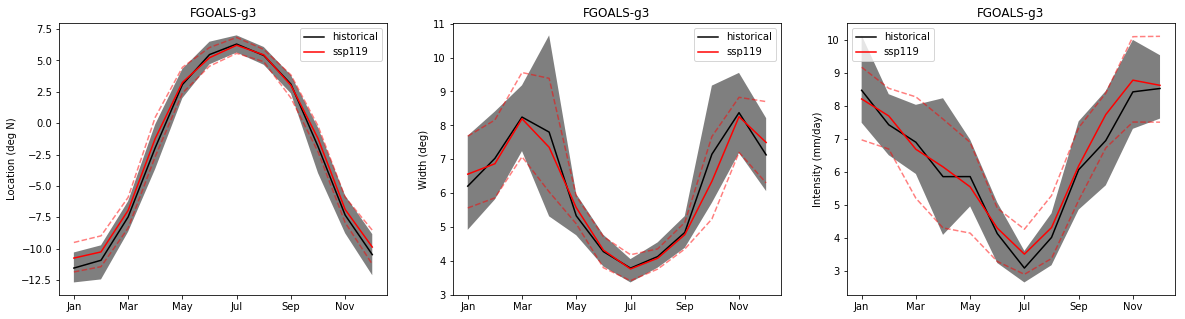

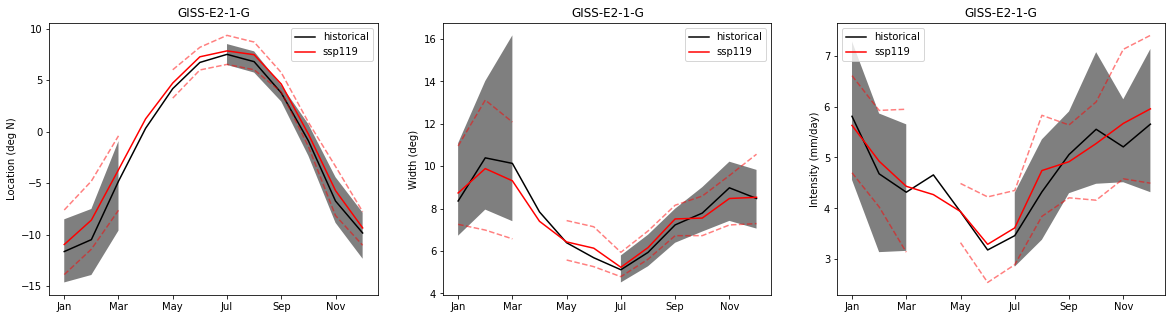

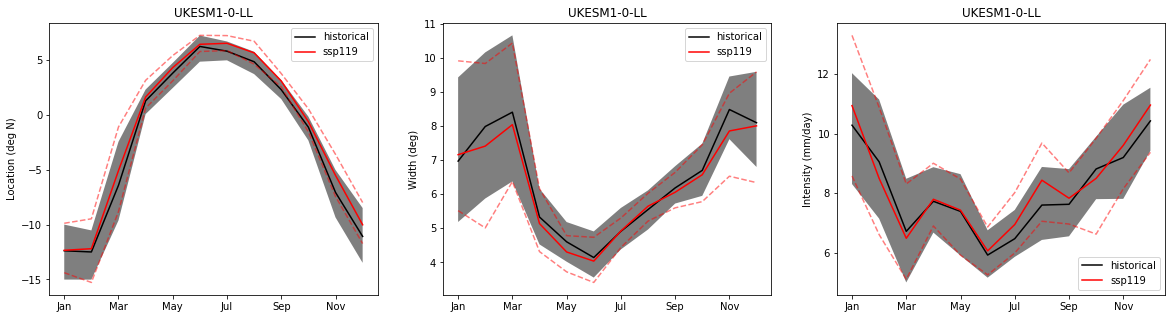

In [12]:
models_with_ssp119 = ['CAMS-CSM1-0', 'CanESM5', 'CNRM-ESM2-1', 'FGOALS-g3', 'GISS-E2-1-G', 'UKESM1-0-LL']
for i, model in enumerate(models_with_ssp119):
    fig, ax = plt.subplots(1, 3,figsize=(20, 5))
    compare_time_slices_model(model, 'ssp119', 'mean', ax=ax[0])
    compare_time_slices_model(model, 'ssp119', 'width', ax=ax[1])
    compare_time_slices_model(model, 'ssp119', 'amplitude', ax=ax[2])

Compare historical with SSP585

/opt/jaspy/lib/python3.7/site-packages/numpy/lib/function_base.py:3652: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/opt/jaspy/lib/python3.7/site-packages/numpy/lib/function_base.py:3652: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/opt/jaspy/lib/python3.7/site-packages/numpy/lib/function_base.py:3652: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/opt/jaspy/lib/python3.7/site-packages/numpy/lib/function_base.py:3652: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/opt/jaspy/lib/python3.7/site-packages/numpy/lib/function_base.py:3652: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/opt/jaspy/lib/python3.7/site-packages/numpy/lib/function_base.py:3652: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/opt/jaspy/lib/python3.7/site-packages/numpy/l

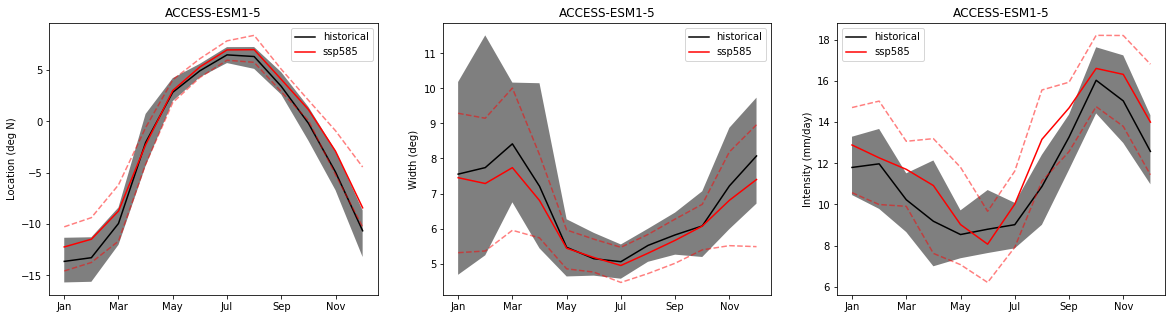

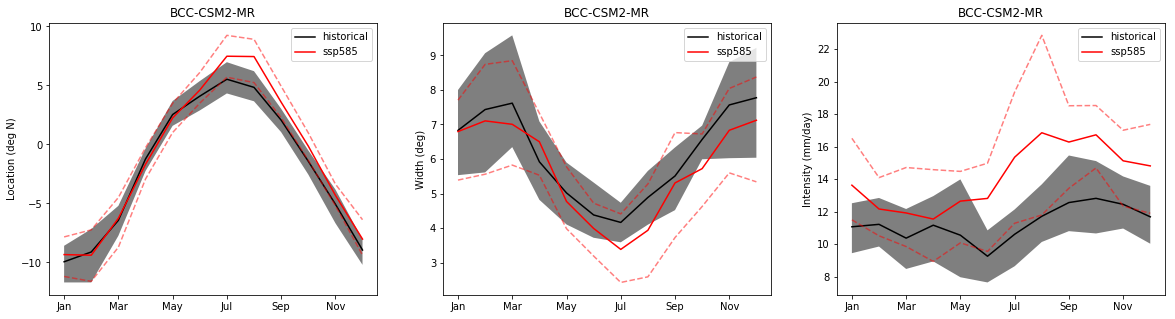

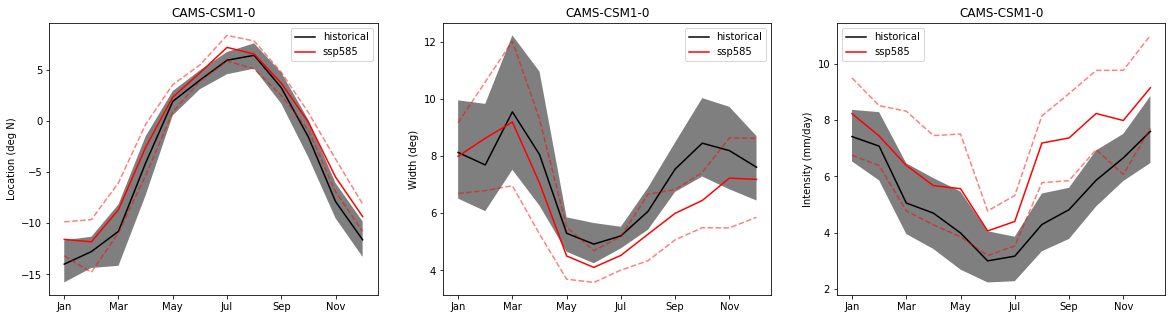

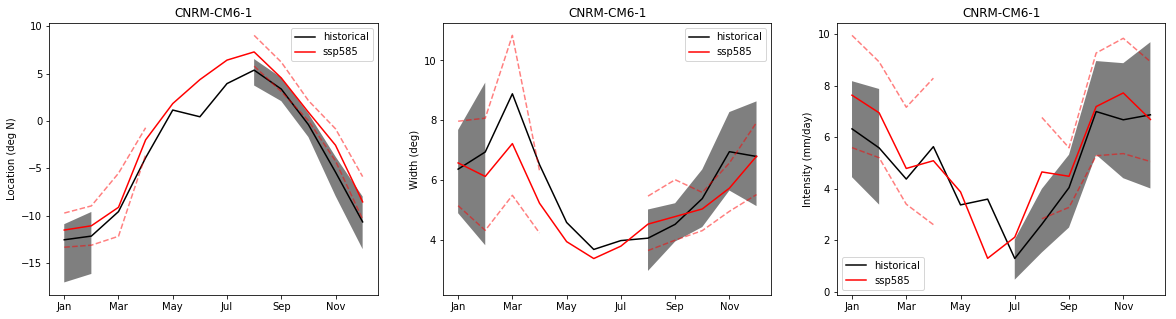

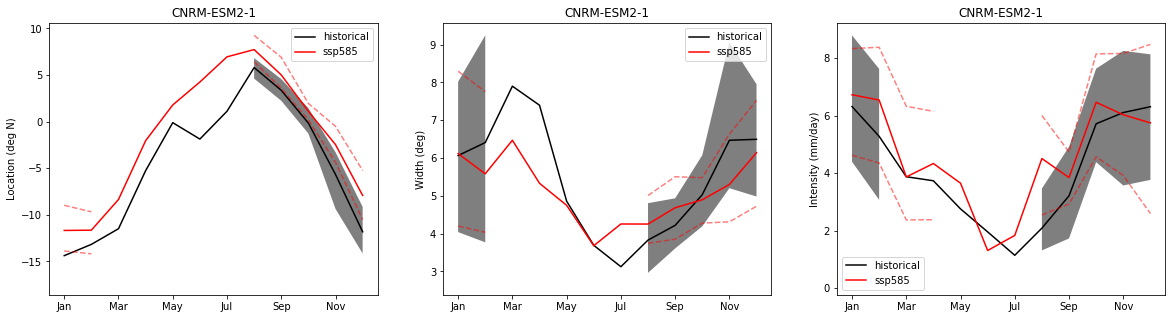

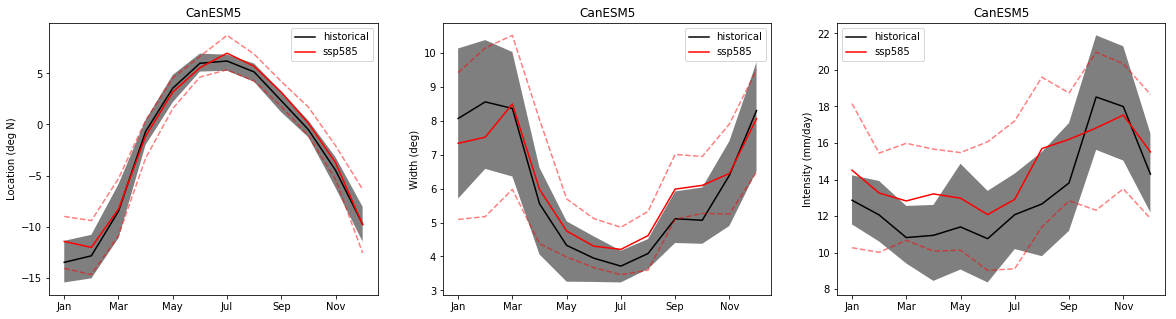

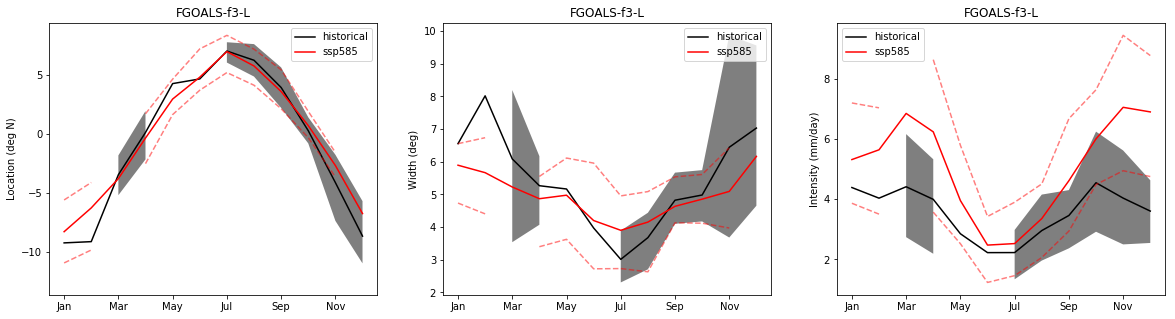

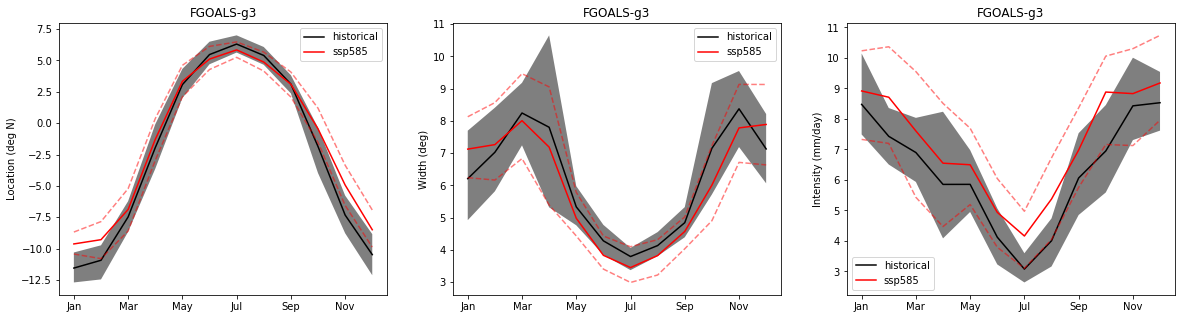

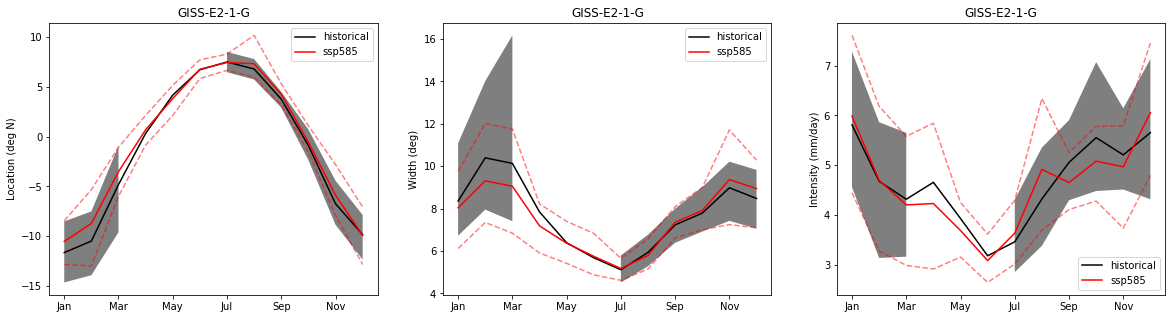

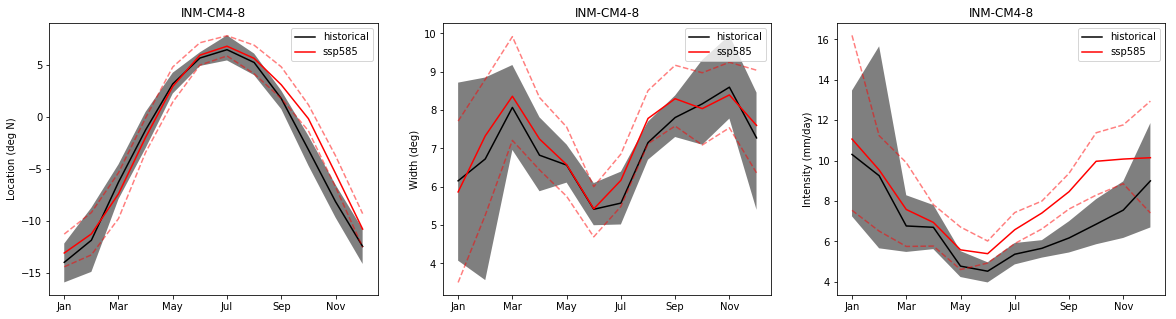

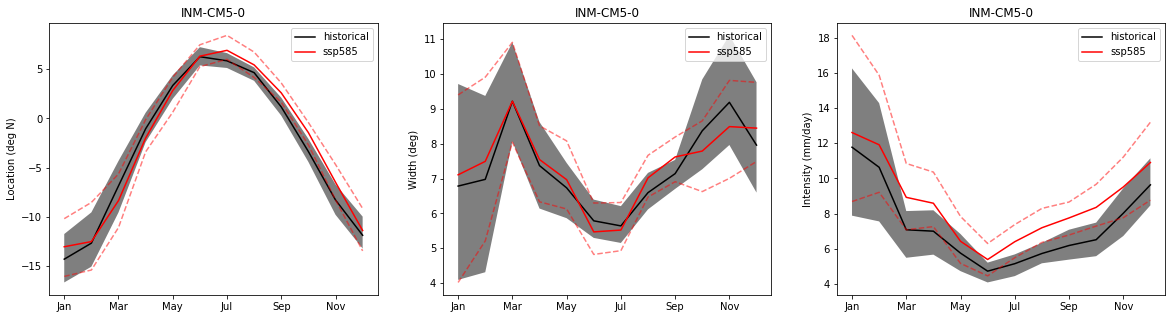

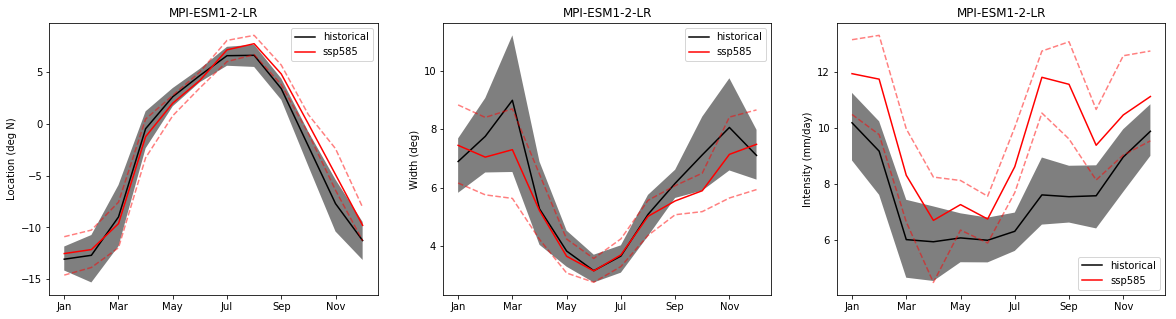

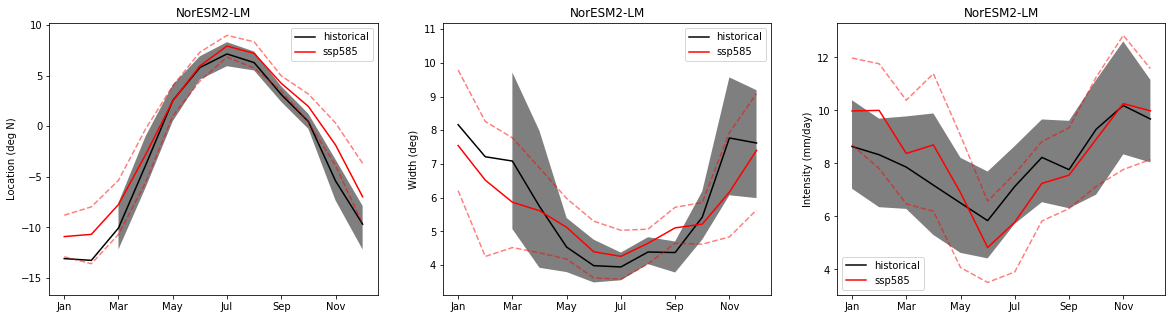

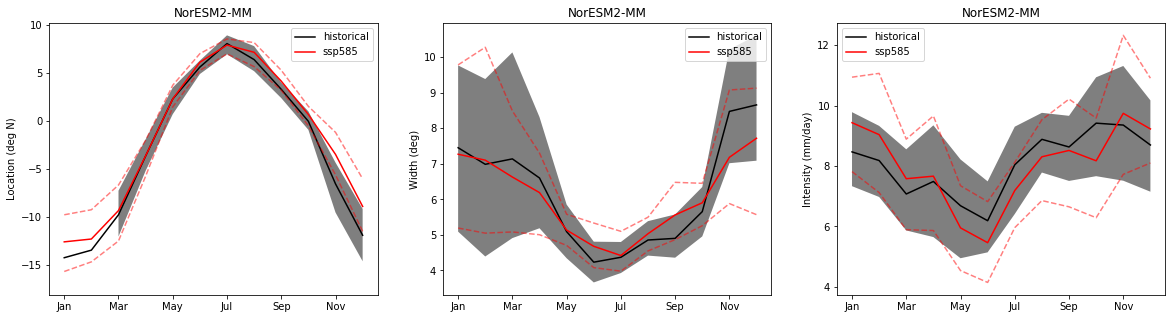

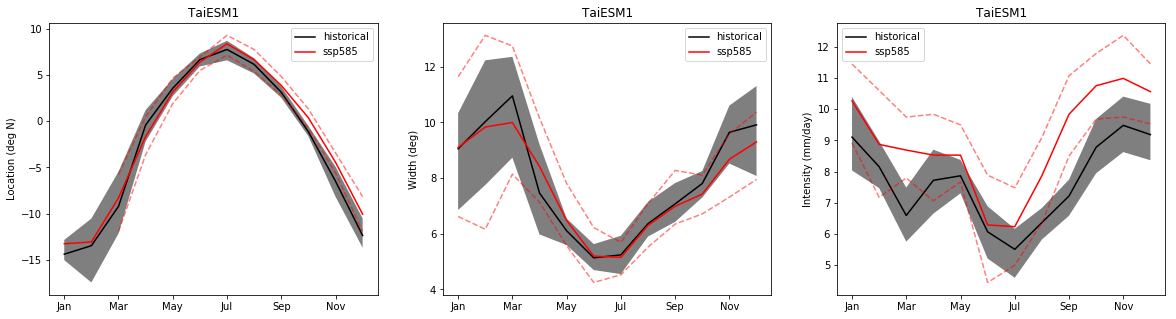

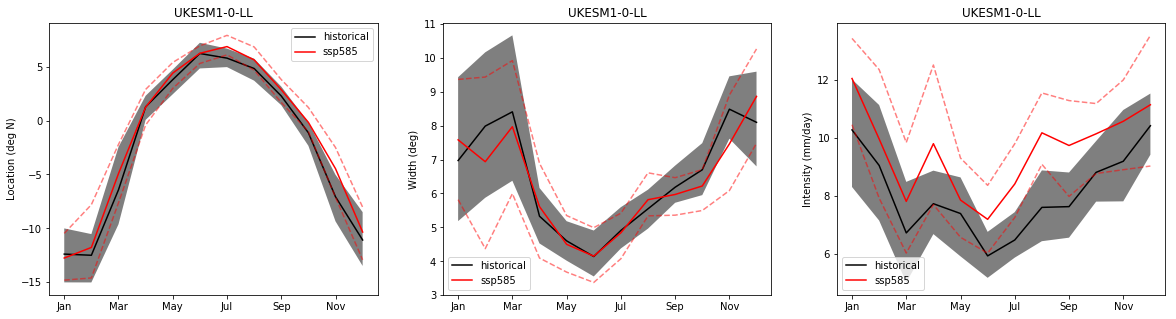

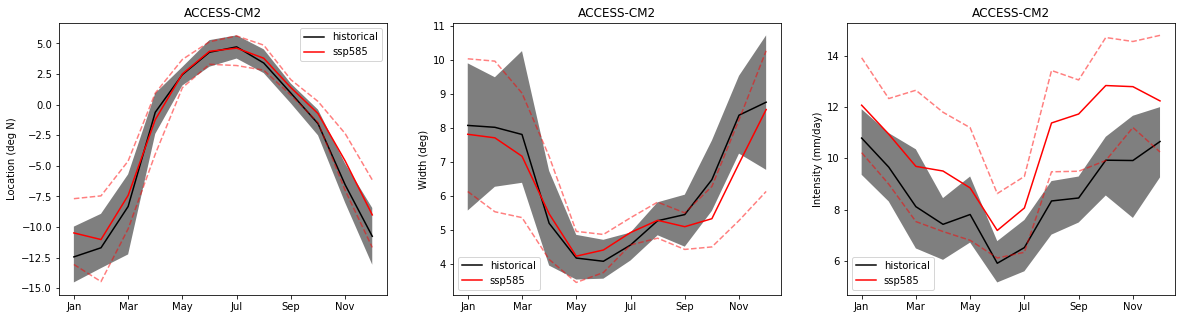

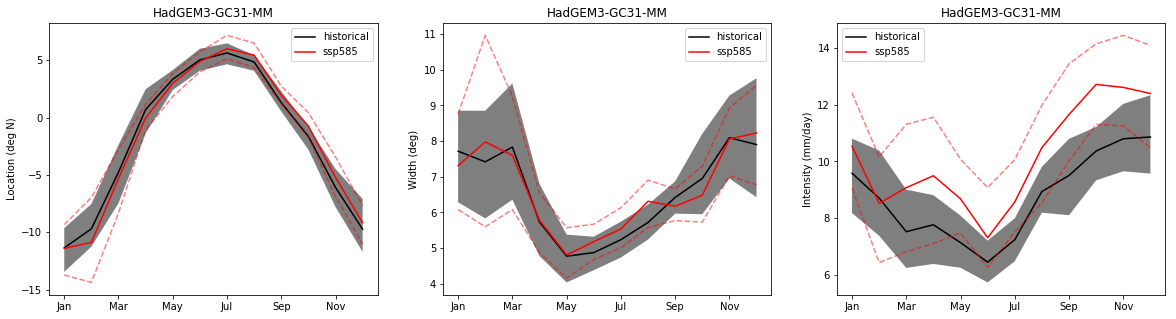

In [13]:
models_with_ssp585 = [f for f in os.listdir("/gws/pw/j05/cop26_hackathons/bristol/project02/data/CMIP6proj/TRBindices/")]
for i, model in enumerate(models_with_ssp585):
    fig, ax = plt.subplots(1, 3,figsize=(20, 5))
    compare_time_slices_model(model, 'ssp585', 'mean', ax=ax[0])
    compare_time_slices_model(model, 'ssp585', 'width', ax=ax[1])
    compare_time_slices_model(model, 'ssp585', 'amplitude', ax=ax[2])

# Changes in seasonal mean TRB indices by model

In [14]:
def mean_TRB_indices(model_name, trb_index, season):
    datasets = {}
    datasets['historical'] = historical_indices(model_name)
    datasets['proj585'] = future_indices(model_name, 'ssp585')
    try:
        datasets['proj119'] = future_indices(model_name, 'ssp119')
    except FileNotFoundError:
        print(f'No SSP1 for {model_name}')   
    
    expts = datasets.keys()
    trb_indices = {expt: datasets[expt].gaussian_params.sel(popt=trb_index) for expt in expts}

    for expt in expts:
        if trb_index == 'width':
            trb_indices[expt] = np.fabs(trb_indices[expt])
            trb_indices[expt] = xr.where(trb_indices[expt] < 20., trb_indices[expt], np.nan)
        elif trb_index == 'mean':
            trb_indices[expt] = xr.where(np.fabs(trb_indices[expt]) < 25., trb_indices[expt], np.nan)
        elif trb_index == 'amplitude':
            trb_indices[expt] = xr.where(trb_indices[expt] < 50., trb_indices[expt], np.nan)
    
    trb_indices_seasonal = {expt: trb_indices[expt].groupby("time.season").mean("time").sel(season=season) for expt in expts}
    return trb_indices_seasonal

In [15]:
def compare_mean_indices(list_of_models, trb_index, season, ax=None, show_ssp1=True):
    number_of_models = len(list_of_models)
    x = np.arange(number_of_models)
    model_difference_ssp119 = []
    model_difference_ssp585 = []
    for model in list_of_models:
        indices = mean_TRB_indices(model, trb_index, season)
        if 'proj119' in indices.keys():
            model_difference_ssp119.append(indices['proj119'].values - indices['historical'].values)
        else:
            model_difference_ssp119.append(np.nan)
        model_difference_ssp585.append(indices['proj585'].values - indices['historical'].values)
    if not ax:
        ax = plt.figure(figsize=(6, 4.5)).gca()
    if show_ssp1:
        ax.scatter(x, model_difference_ssp119, c='r', s=100, label='SSP1 - historical')
        ax.scatter(x, model_difference_ssp585, c='k', s=100, label='SSP5 - historical')
        ax.legend(loc='best', fontsize=14)
    else:
        ax.bar(x, model_difference_ssp585, color='k')
    ax.axhline(0, linestyle='--', color='gray', alpha=0.5)
    ax.set_xticks(x)
    ax.set_xticklabels(list_of_models, rotation=90)
    ax.tick_params(labelsize=14)

    ax.set_ylabel(f'change in mean TRB {trb_index_label(trb_index)}', fontsize=14)
    ax.set_title(season, fontsize=14)
    return ax

In [16]:
def summer_winter_index_changes(list_of_models, trb_index, show_ssp1=True):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    compare_mean_indices(list_of_models, trb_index, 'JJA', ax=axs[0], show_ssp1=show_ssp1)
    compare_mean_indices(list_of_models, trb_index, 'DJF', ax=axs[1], show_ssp1=show_ssp1)

For the models with data for both SSPs 1 and 5, plot the changes in TRB indices from the historical period (1970-2000) to the future period (2070-2100) for each SSP.

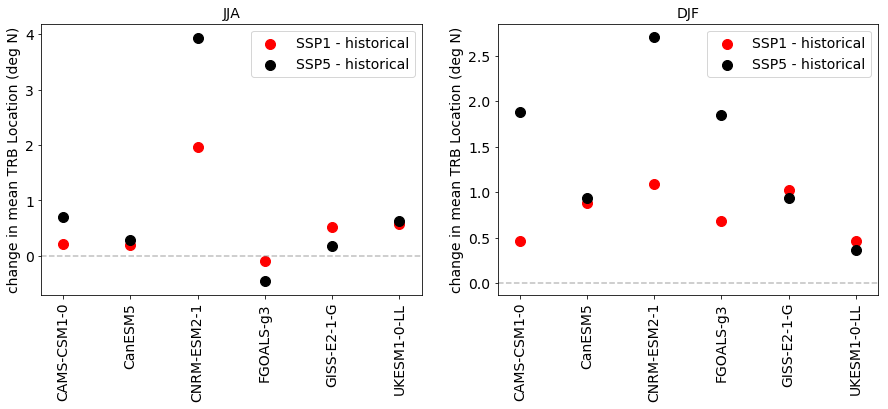

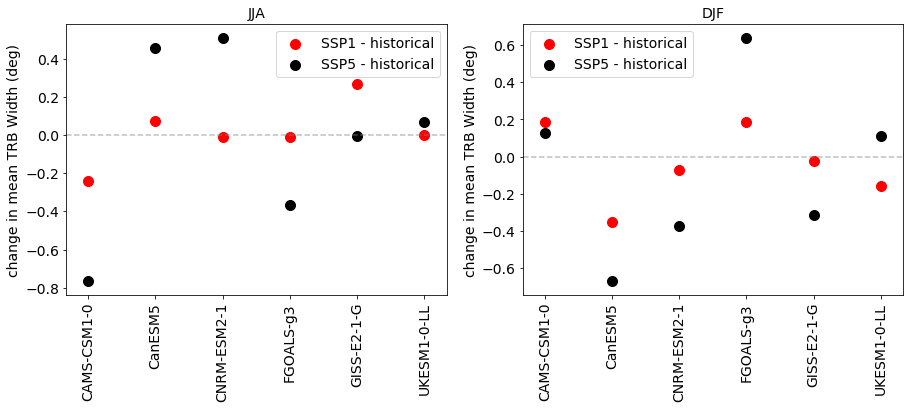

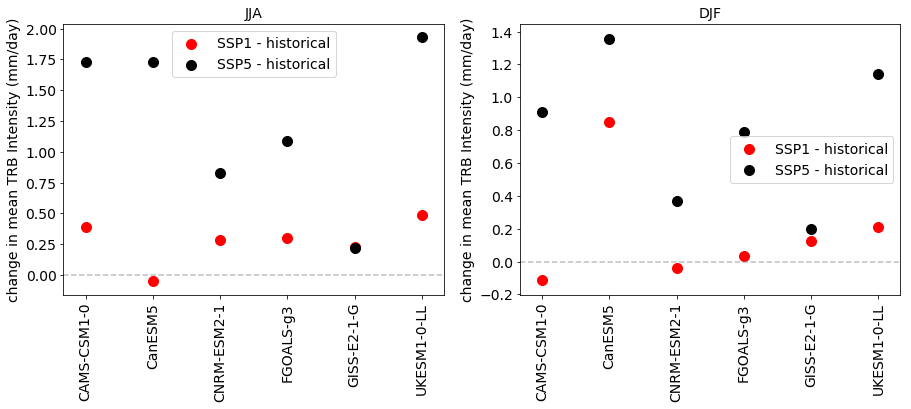

In [17]:
models_with_ssp119 = ['CAMS-CSM1-0', 'CanESM5', 'CNRM-ESM2-1', 'FGOALS-g3', 'GISS-E2-1-G', 'UKESM1-0-LL']
summer_winter_index_changes(models_with_ssp119, 'mean')
summer_winter_index_changes(models_with_ssp119, 'width')
summer_winter_index_changes(models_with_ssp119, 'amplitude')

For all models, plot the changes in the mean values of the TRB indices in JJA and DJF from the historical simulations (1970-2000) to the projected future (2070-2100) under SSP5.

No SSP1 for ACCESS-CM2
No SSP1 for ACCESS-ESM1-5
No SSP1 for BCC-CSM2-MR
No SSP1 for CNRM-CM6-1
No SSP1 for FGOALS-f3-L
No SSP1 for HadGEM3-GC31-MM
No SSP1 for INM-CM4-8
No SSP1 for INM-CM5-0
No SSP1 for MPI-ESM1-2-LR
No SSP1 for NorESM2-LM
No SSP1 for NorESM2-MM
No SSP1 for TaiESM1
No SSP1 for ACCESS-CM2
No SSP1 for ACCESS-ESM1-5
No SSP1 for BCC-CSM2-MR
No SSP1 for CNRM-CM6-1
No SSP1 for FGOALS-f3-L
No SSP1 for HadGEM3-GC31-MM
No SSP1 for INM-CM4-8
No SSP1 for INM-CM5-0
No SSP1 for MPI-ESM1-2-LR
No SSP1 for NorESM2-LM
No SSP1 for NorESM2-MM
No SSP1 for TaiESM1
No SSP1 for ACCESS-CM2
No SSP1 for ACCESS-ESM1-5
No SSP1 for BCC-CSM2-MR
No SSP1 for CNRM-CM6-1
No SSP1 for FGOALS-f3-L
No SSP1 for HadGEM3-GC31-MM
No SSP1 for INM-CM4-8
No SSP1 for INM-CM5-0
No SSP1 for MPI-ESM1-2-LR
No SSP1 for NorESM2-LM
No SSP1 for NorESM2-MM
No SSP1 for TaiESM1
No SSP1 for ACCESS-CM2
No SSP1 for ACCESS-ESM1-5
No SSP1 for BCC-CSM2-MR
No SSP1 for CNRM-CM6-1
No SSP1 for FGOALS-f3-L
No SSP1 for HadGEM3-GC31-MM


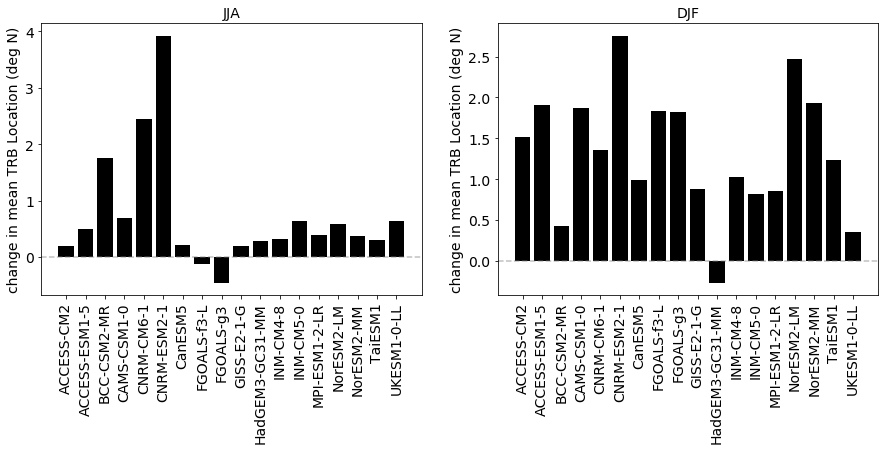

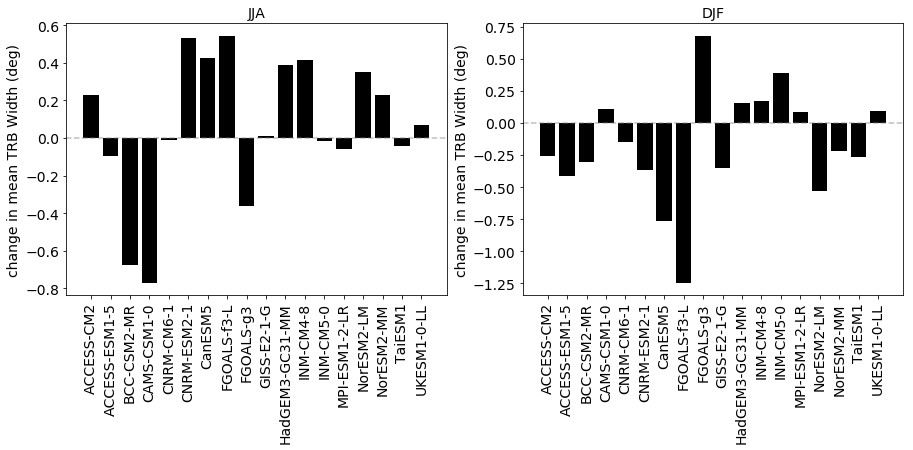

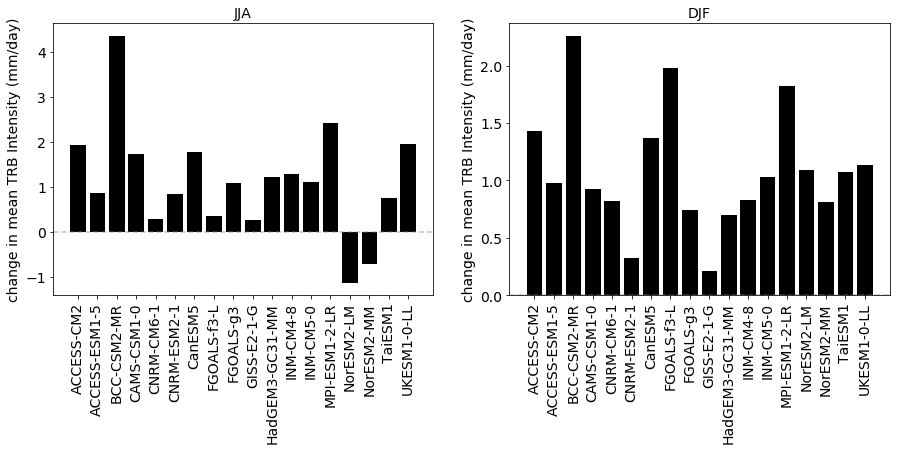

In [174]:
models_with_ssp585 = sorted([f for f in os.listdir("/gws/pw/j05/cop26_hackathons/bristol/project02/data/CMIP6proj/TRBindices/")])
summer_winter_index_changes(models_with_ssp585, 'mean', show_ssp1=False)
plt.savefig("/home/users/train057/figures/CMIP6_SSP5_TRB_location_changes.png", dpi=300, bbox_inches='tight')
summer_winter_index_changes(models_with_ssp585, 'width', show_ssp1=False)
plt.savefig("/home/users/train057/figures/CMIP6_SSP5_TRB_width_changes.png", dpi=300, bbox_inches='tight')
summer_winter_index_changes(models_with_ssp585, 'amplitude', show_ssp1=False)
plt.savefig("/home/users/train057/figures/CMIP6_SSP5_TRB_intensity_changes.png", dpi=300, bbox_inches='tight')

Show interannual spread in both historical and future periods for each model (excluding models that have poorer Gaussian fits for the TRB)

In [147]:
def season_TRB_indices(model_name, trb_index, season):
    datasets = {}
    datasets['gpcc'] = gpcc_indices()
    datasets['historical'] = historical_indices(model_name)
    datasets['proj585'] = future_indices(model_name, 'ssp585')
    try:
        datasets['proj119'] = future_indices(model_name, 'ssp119')
    except FileNotFoundError:
        print(f'No SSP1 for {model_name}')   
    
    expts = datasets.keys()
    trb_indices = {expt: datasets[expt].gaussian_params.sel(popt=trb_index) for expt in expts}

    for expt in expts:
        if trb_index == 'width':
            trb_indices[expt] = np.fabs(trb_indices[expt])
            trb_indices[expt] = xr.where(trb_indices[expt] < 20., trb_indices[expt], np.nan)
        elif trb_index == 'mean':
            trb_indices[expt] = xr.where(np.fabs(trb_indices[expt]) < 25., trb_indices[expt], np.nan)
        elif trb_index == 'amplitude':
            trb_indices[expt] = xr.where(trb_indices[expt] < 50., trb_indices[expt], np.nan)
    
    seasonal_means = {}
    for expt in expts:
        iris_trb_index = xr.DataArray.to_iris(trb_indices[expt])
        iris.coord_categorisation.add_season(iris_trb_index, 'time', name='clim_season')
        iris.coord_categorisation.add_season_year(iris_trb_index, 'time', name='season_year')
        annual_seasonal_mean = iris_trb_index.aggregated_by(['clim_season', 'season_year'], iris.analysis.MEAN)
        means_in_season = annual_seasonal_mean.extract(iris.Constraint(clim_season=lambda c:c==season.lower()))
        seasonal_means[expt] = xr.DataArray.from_iris(means_in_season)
    return seasonal_means

In [163]:
def compare_seasonal_indices(list_of_models, trb_index, season, ax=None):
    number_of_models = len(list_of_models)
    x = np.arange(number_of_models)
    means_historical = {}
    means_future = {}
    for model in list_of_models:
        indices = season_TRB_indices(model, trb_index, season)
        means_historical[model] = indices['historical'].values
        means_future[model] = indices['proj585'].values
    means_gpcc = indices['gpcc'].values
    if not ax:
        ax = plt.figure(figsize=(10, 4)).gca()
    ax.boxplot(means_gpcc, widths=0.2, whis=(10,90), showfliers=False, medianprops=dict(color="#34cceb"), boxprops=dict(color="#34cceb"), whiskerprops=dict(color="#34cceb"), capprops=dict(color="#34cceb"), positions=[1])
    ax.boxplot(means_historical.values(), widths=0.2, whis=(10,90), showfliers=False, medianprops=dict(color="black"), boxprops=dict(color="black"), whiskerprops=dict(color="black"), capprops=dict(color="black"), positions=(x+2-0.15))
    ax.boxplot(means_future.values(), widths=0.2, whis=(10,90), showfliers=False, medianprops=dict(color="red"), boxprops=dict(color="red"), whiskerprops=dict(color="red"), capprops=dict(color="red"), positions=(x+2+0.15))
    ax.set_xticks(np.arange(number_of_models+1)+1)
    ax.set_xticklabels(['GPCC'] + list(means_historical.keys()), rotation=90)
    ax.tick_params(labelsize=14)
    ax.set_xlim([0, number_of_models+2])
    ax.set_ylabel(f'mean TRB {trb_index_label(trb_index)}', fontsize=14)
    custom_lines = [Line2D([0], [0], color='#34cceb', lw=1),
                    Line2D([0], [0], color='k', lw=1),
                    Line2D([0], [0], color='r', lw=1)]
    ax.legend(custom_lines, ['obs', 'historical', 'ssp585'], loc='best', fontsize=14)
    ax.set_title(season, fontsize=14)
    return ax

In [171]:
def summer_winter_index_changes_boxplots(list_of_models, trb_index):
    fig, axs = plt.subplots(1, 2, figsize=(25, 4))
    compare_seasonal_indices(list_of_models, trb_index, 'JJA', ax=axs[0])
    compare_seasonal_indices(list_of_models, trb_index, 'DJF', ax=axs[1])

No SSP1 for ACCESS-CM2
No SSP1 for ACCESS-ESM1-5
No SSP1 for BCC-CSM2-MR
No SSP1 for HadGEM3-GC31-MM
No SSP1 for INM-CM4-8
No SSP1 for INM-CM5-0
No SSP1 for MPI-ESM1-2-LR
No SSP1 for NorESM2-LM
No SSP1 for NorESM2-MM
No SSP1 for TaiESM1
No SSP1 for ACCESS-CM2
No SSP1 for ACCESS-ESM1-5
No SSP1 for BCC-CSM2-MR
No SSP1 for HadGEM3-GC31-MM
No SSP1 for INM-CM4-8
No SSP1 for INM-CM5-0
No SSP1 for MPI-ESM1-2-LR
No SSP1 for NorESM2-LM
No SSP1 for NorESM2-MM
No SSP1 for TaiESM1
No SSP1 for ACCESS-CM2
No SSP1 for ACCESS-ESM1-5
No SSP1 for BCC-CSM2-MR
No SSP1 for HadGEM3-GC31-MM
No SSP1 for INM-CM4-8
No SSP1 for INM-CM5-0
No SSP1 for MPI-ESM1-2-LR
No SSP1 for NorESM2-LM
No SSP1 for NorESM2-MM
No SSP1 for TaiESM1
No SSP1 for ACCESS-CM2
No SSP1 for ACCESS-ESM1-5
No SSP1 for BCC-CSM2-MR
No SSP1 for HadGEM3-GC31-MM
No SSP1 for INM-CM4-8
No SSP1 for INM-CM5-0
No SSP1 for MPI-ESM1-2-LR
No SSP1 for NorESM2-LM
No SSP1 for NorESM2-MM
No SSP1 for TaiESM1
No SSP1 for ACCESS-CM2
No SSP1 for ACCESS-ESM1-5
No 

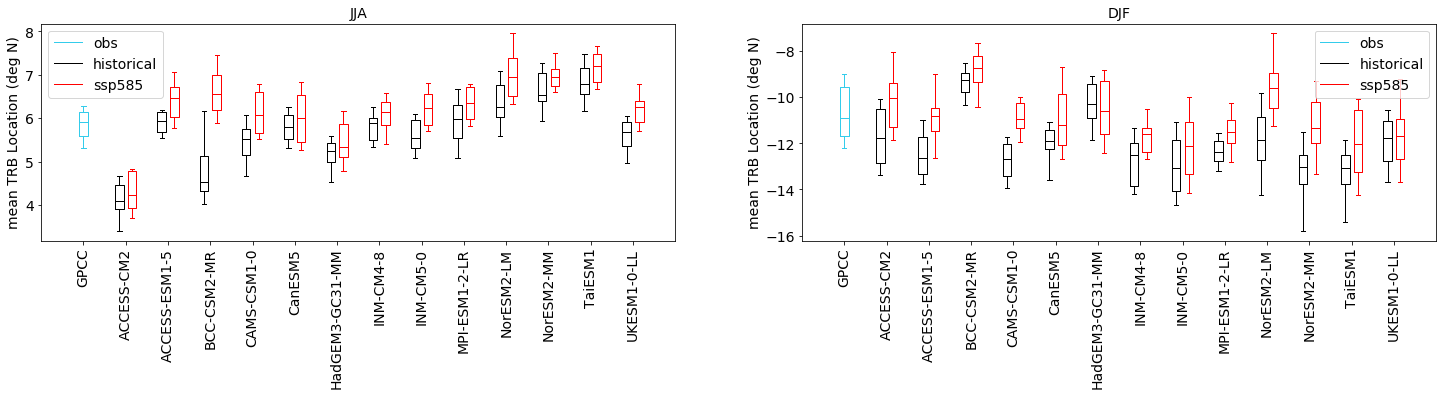

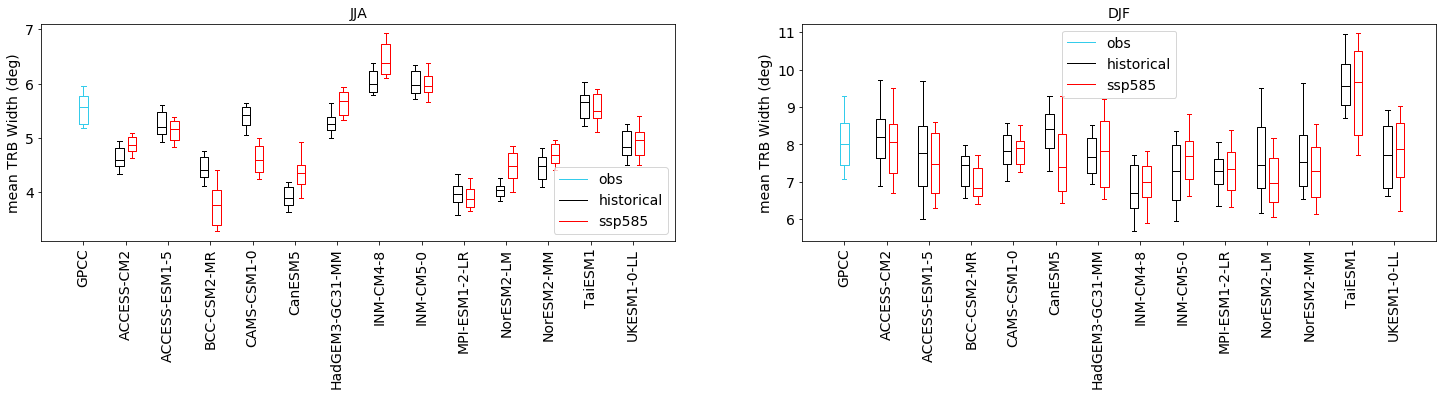

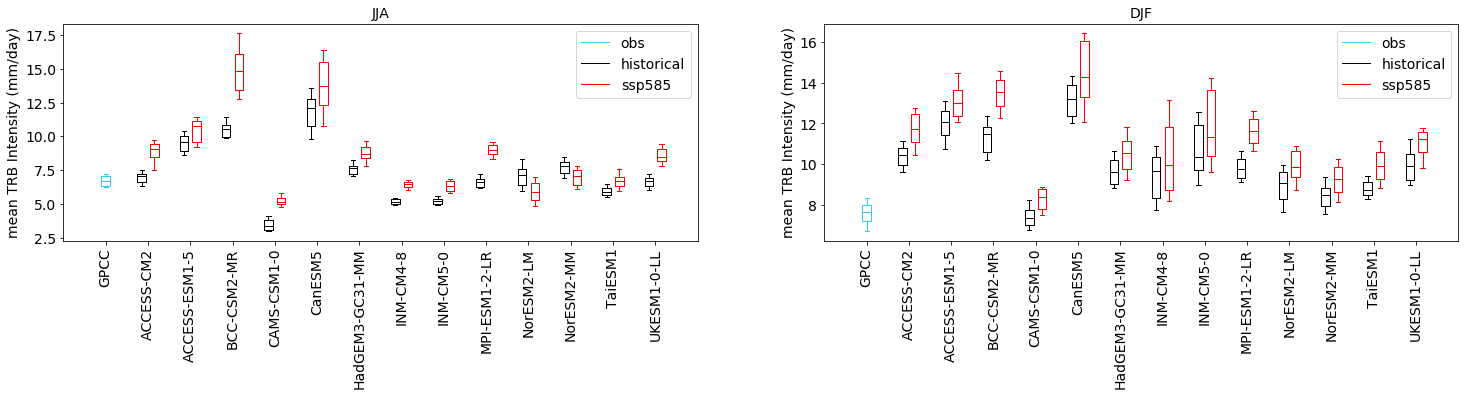

In [172]:
bad_fit_models = ['CNRM', 'GISS', 'FGOALS'] # don't include models with poor mean r^2 for the Gaussian TRB fitting
list_of_models = sorted([f for f in os.listdir("/gws/pw/j05/cop26_hackathons/bristol/project02/data/CMIP6proj/TRBindices/") if not any(b in f for b in bad_fit_models)])
summer_winter_index_changes_boxplots(list_of_models, 'mean')
plt.savefig("/home/users/train057/figures/CMIP6_SSP5_TRB_location_changes_boxplots.png", dpi=300, bbox_inches='tight')
summer_winter_index_changes_boxplots(list_of_models, 'width')
plt.savefig("/home/users/train057/figures/CMIP6_SSP5_TRB_width_changes_boxplots.png", dpi=300, bbox_inches='tight')
summer_winter_index_changes_boxplots(list_of_models, 'amplitude')
plt.savefig("/home/users/train057/figures/CMIP6_SSP5_TRB_intensity_changes_boxplots.png", dpi=300, bbox_inches='tight')